# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
import pandas as pd
import numpy as np
DATA_FOLDER = './data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

## Library

In [2]:
# To list file and folder dynamically
from os import listdir

## Functions

In [3]:
""" 
    Function to merge all data into one single dataframe
    @params: (string) directory, path to ebola data
    @params: (list of string) list_countries, available countries that we want to crawl data for
    return: (panda dataframe) data containing all ebola information
"""
def crawl_data(directory, list_countries):
    data = []

    for country in list_countries:
        # list all available data per country
        country_data_files = listdir(directory + "/" + country + "_data")
        country_data = []
        
        # for each csv file, read and store it to single list
        for country_data_file in country_data_files:
            # get the absoulte path of each csv file
            csv_file = (directory + "/" + country + "_data/" + country_data_file)
            
            # read data, use "Date" (column 0) as index, parse dates format, and make "-" character as NaN
            data_per_country_date = pd.read_csv(csv_file, index_col=[0], parse_dates=[0], na_values=['-'])
            
            # append to list
            country_data.append(data_per_country_date)
        
        # merge one country data as one single dataframe
        country_data = pd.concat(country_data)
        # append the country's dataframe into list
        data.append(country_data)

    # Form a single DataFrame for all countries, use countries' name as keys    
    data = pd.concat(data,keys=list_countries)
    # Name the index
    data.index.names = ["Country","Date"]
    # return the formed dataframe
    return data

""" 
    Function to get the daily average per month of new cases and new deaths for a country
    @params: (panda dataframe) data, dataframe containing all sources of information
    @params: (string) country, the name of country
    @params: (string) col_descriptor, the name of column used to describe records
    @params: (list of string) keywords, the descriptions that we want to account for
    @params: (string) field, the column that we "assume" contain the sum of a record
    return: (panda series) a series containing data of daily average per month for given keywords
"""
def extract_data(data, country, col_descriptor, keywords, field):
    # find the index of given country, filter based on keywords found in col_descriptor
    index = data.loc[country][col_descriptor].isin(keywords)
    # reduce the big dataframe into df, fill NaN with zeros
    df = (data.loc[country][index].fillna(value=0.0))
    
    # find the information for month and year of country's data
    date = df.index.month
    year = df.index.year
    
    # create two dataframe: 
    # df1 is used to calculate based on sum of all columns per record (per row)
    # df2 is used to calculate based on "assumed" column that contains sum per category
    df1 = df
    df2 = df
    
    ######################################################
    # throw the column that "assumed" contains total values per record (per row)
    df1 = df1.drop([field],axis=1)
    
    # throw the column of descriptor, since we have used it to form df
    df1 = df1.drop([col_descriptor],axis=1)
    
    # change the entries into float
    df1 = df1.apply(pd.to_numeric)
    
    # sum the data per record (per row)
    df1 = df1.sum(axis=1)
    
    # group the data based on month,year and sum it based on the grouping
    df1 = (pd.Series.groupby(df1,by=[date,year])).sum()
    
    # give names to series index
    df1.index.names = ["Month","Year"]
    # finish forming series df1, contains sum of all columns per record (per row)
    ######################################################
    
    ######################################################
    # change the datatype of column that "assumed" contains total values per record (per row)
    df2[field] = df2[field].astype(float)
    
    # group the data based on month,year and sum it "assumed" column
    df2 = (pd.DataFrame.groupby(df2,by=[date,year]))[field].sum()
    
    # give names to series index
    df2.index.names = ["Month","Year"]
    # finish forming series df2, contains "assumed" sum of data per record (per row)
    ######################################################
    
    """
        Consider both result by comparing series df1 and df2
        We assume that the largest entry per index represent the real sum of data per records
    """
    
    # index1 contains all true indexs in which df1 > df2
    index1 = (df1 >= df2)
    
    # index2 contains all true indexs in which df2 > df1
    index2 = (~index1)
    
    # form the final result by adding both df and dividing by 30 (average per day, 1 month=30 days)
    # we asssume that within a month, there are no new cases and death cases aside from what are being written in reports
    result_series = (df1[index1].add(df2[index2], fill_value=0))/30
    
    return result_series

## Vars

In [4]:
# Assign Static Values
EBOLA_DATA_DIR = DATA_FOLDER + "/ebola"

# list countries dynamically
countries = [c[:-5] for c in listdir(EBOLA_DATA_DIR) if c != "LICENSE"]

# save all data into single panda dataframe var
ebola_data = crawl_data(EBOLA_DATA_DIR,countries)

## Results

In [16]:
### For guinea ###
# Keywords for New cases: New cases of suspects, New cases of probables, New cases of confirmed
# Keywords for New deaths: New deaths registered
# Column "Description" gives detail of each record (row)
# Column "Totals" is assumed to contain the sum of data per description
guinea_new_cases_label = ["New cases of suspects","New cases of probables", "New cases of confirmed"]
guinea_new_deaths_label = [ "New deaths registered" ]

guinea_new_cases = extract_data(ebola_data, "guinea", "Description", guinea_new_cases_label, "Totals")
guinea_new_deaths = extract_data(ebola_data, "guinea", "Description", guinea_new_deaths_label, "Totals")

guinea_new_cases = pd.DataFrame(guinea_new_cases, columns=['daily avg/month'])
guinea_new_deaths = pd.DataFrame(guinea_new_deaths, columns=['daily avg/month'])

display(guinea_new_cases)
display(guinea_new_deaths)

,,daily avg/month
Month,Year,
8,2014,4.300000
9,2014,10.466667
10,2014,1.133333


,,daily avg/month
Month,Year,
8,2014,0.5
9,2014,1.9
10,2014,0.5


In [17]:
### For liberia ###
# Keywords for New cases: New Case/s (Suspected), New Case/s (Probable), New case/s (confirmed)
# Keywords for New deaths: Newly reported deaths
# Column "Variable" gives detail of each record (row)
# Column "National" is assumed to contain the sum of data per variable
liberia_new_cases_label = ["New Case/s (Suspected)","New Case/s (Probable)", "New case/s (confirmed)"]
liberia_new_deaths_label = [ "Newly reported deaths" ]

liberia_new_cases = extract_data(ebola_data, "liberia", "Variable", liberia_new_cases_label, "National")
liberia_new_deaths = extract_data(ebola_data, "liberia", "Variable", liberia_new_deaths_label, "National")

liberia_new_cases = pd.DataFrame(liberia_new_cases, columns=['daily avg/month'])
liberia_new_deaths = pd.DataFrame(liberia_new_deaths, columns=['daily avg/month'])

display(liberia_new_cases)
display(liberia_new_deaths)

,,daily avg/month
Month,Year,
6,2014,1.333333
7,2014,3.133333
8,2014,11.166667
9,2014,51.066667
10,2014,38.433333
11,2014,15.666667
12,2014,1553.566667


,,daily avg/month
Month,Year,
6,2014,0.466667
7,2014,1.566667
8,2014,6.966667
9,2014,28.833333
10,2014,23.433333
11,2014,6.833333
12,2014,0.000000


In [18]:
### For SL ###
# Keywords for New cases: new_suspected, new_probable, new_confirmed
# Keywords for new deaths : etc_new_deaths
# Column "variable" gives detail of each record (row)
# Column "National" is assumed to contain the sum of data per variable
sl_new_cases_label = ["new_suspected", "new_probable", "new_confirmed"]
sl_new_deaths_label = [ "etc_new_deaths" ]

sl_new_cases = extract_data(ebola_data, "sl", "variable", sl_new_cases_label, "National")
sl_new_deaths = extract_data(ebola_data, "sl", "variable", sl_new_deaths_label, "National")

sl_new_cases = pd.DataFrame(sl_new_cases, columns=['daily avg/month'])
sl_new_deaths = pd.DataFrame(sl_new_deaths, columns=['daily avg/month'])

display(sl_new_cases)
display(sl_new_deaths)

,,daily avg/month
Month,Year,
8,2014,17.766667
9,2014,41.400000
10,2014,67.133333
11,2014,55.000000
12,2014,6.833333


,,daily avg/month
Month,Year,
8,2014,3.700000
9,2014,4.200000
10,2014,3.300000
11,2014,0.400000
12,2014,0.366667


## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [42]:
import os

frame = pd.DataFrame()
files = os.listdir(DATA_FOLDER+"/microbiome")
i=1
for f in files:
    if(f.startswith('MID')):
        frame = frame.append(pd.read_excel("data/microbiome/"+f,names=['NAME','Value'+repr(i)], header=None))
        i+=1
        
frame = frame.groupby('NAME').sum()
#frame = frame.reset_index()  #If not used, names are used as index
frame = frame.fillna('Unknown')

#Metadata import
metadata = pd.DataFrame(pd.read_excel("data/microbiome/metadata.xls"))
legend = (metadata['SAMPLE'].fillna('Unknown')+', '+metadata['GROUP']).tolist()
frame.columns = legend

#Merges sample types
a = frame.columns.str.split(', ', expand=True).values
frame.columns = pd.MultiIndex.from_tuples([('', x[0]) if pd.isnull(x[1]) else x for x in a])
frame.columns.names = reversed(metadata.columns[1::])
frame

SAMPLE                                                        Unknown  \
GROUP                                              EXTRACTION CONTROL   
NAME                                                                    
Archaea "Crenarchaeota" Thermoprotei Acidilobal...            Unknown   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...            Unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...                  7   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...            Unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...            Unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...            Unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...            Unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...            Unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...            Unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...                  2   
Archaea "Crenarchaeota" Thermoprotei Sulfolobal...                  3   
Archaea "Crenarchaeota" Thermoprotei Sulfolobal...            Unknown   
Archaea "Crenarchaeota" Thermoprotei Thermoprot...                  3   
Archaea "Crenarchaeota" Thermoprotei Thermoprot...            Unknown   
Archaea "Crenarchaeota" Thermoprotei Thermoprot...            Unknown   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...                  7   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...            Unknown   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...            Unknown   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...            Unknown   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...            Unknown   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...                  1   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...            Unknown   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...                  1   
Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...                  1   
Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...                  1   
Archaea "Euryarchaeota" Halobacteria Halobacter...            Unknown   
Archaea "Euryarchaeota" Halobacteria Halobacter...            Unknown   
Archaea "Euryarchaeota" Halobacteria Halobacter...            Unknown   
Archaea "Euryarchaeota" Halobacteria Halobacter...                  1   
Archaea "Euryarchaeota" Halobacteria Halobacter...                  4   
...                                                               ...   
Bacteria "Proteobacteria" Gammaproteobacteria X...            Unknown   
Bacteria "Proteobacteria" Gammaproteobacteria X...            Unknown   
Bacteria "Proteobacteria" Gammaproteobacteria X...            Unknown   
Bacteria "Proteobacteria" Gammaproteobacteria X...            Unknown   
Bacteria "Proteobacteria" Gammaproteobacteria X...            Unknown   
Bacteria "Proteobacteria" Gammaproteobacteria X...            Unknown   
Bacteria "Spirochaetes" Spirochaetes Spirochaet...                  1   
Bacteria "Synergistetes" Synergistia Synergista...                  2   
Bacteria "Synergistetes" Synergistia Synergista...                  1   
Bacteria "Synergistetes" Synergistia Synergista...                  1   
Bacteria "Tenericutes" Mollicutes Anaeroplasmat...            Unknown   
Bacteria "Tenericutes" Mollicutes Haloplasmatal...                  1   
Bacteria "Thermodesulfobacteria" Thermodesulfob...                  1   
Bacteria "Thermodesulfobacteria" Thermodesulfob...            Unknown   
Bacteria "Thermotogae" Thermotogae Thermotogale...                  7   
Bacteria "Thermotogae" Thermotogae Thermotogale...                  9   
Bacteria "Verrucomicrobia" Opitutae Opitutales ...                  1   
Bacteria "Verrucomicrobia" Opitutae Opitutales ...            Unknown   
Bacteria "Verrucomicrobia" Opitutae Puniceicocc...            Unknown   
Bacteria "Verrucomicrobia" Opitutae Puniceicocc...            Unknown   
Bacteria "Verrucomicrobia" Opitutae Puniceicocc...        

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

## Import libraries

In [1]:
from IPython.core.display import HTML
import pandas as pd
%pylab inline
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copyi2ng a slice from a DataFrame.
from itertools import cycle, islice


Populating the interactive namespace from numpy and matplotlib


## Read file

In [2]:
data = pd.read_excel('Data/titanic.xls')
data.head(10)# show the part of data

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay"


## Cleaning data & Processing data

In [3]:
# ----- Clean cabin -----
# observing the column cabin, we find that only the first letter is useful
# and if we clean it, it could be categorical
data.cabin = data.cabin.dropna().apply(lambda x: x[0])

# ----- Change the value of survive -----------
# 0: not survive, 1:survive
data.survived = ['Not survive' if i == 0 else 'Survive' for i in data.survived]


data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,Survive,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B,S,2,NaN,"St Louis, MO"
1,1,Survive,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,Not survive,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,Not survive,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,Not survive,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


## 1. Describe the type and the value range of each attribute. Indicate and transform the attributes that can be Categorical.

In [4]:
# -------- generate the data frame ----------

stat = pd.DataFrame(index = data.columns, columns=['type', 'value_range', 'categorical'])


# --------- find the data type ----------
stat.type = [data[i].dtype for i in data.columns]

# --------- find the value range ------------
# for those values with number, we use min and max to find the range
stat.value_range = [ "[" + str(data[i].min()) + "," + str(data[i].max()) + "]" if data[i].dtype != 'object' else 'NaN' for i in data.columns]

# for those values with string (without number in it), we do it manually
stat.value_range['sex'] = '[male,female]'
data.embarked.value_counts()
stat.value_range['embarked'] = '[S,C,Q]'

# for those value with string and numbers, it's hard to find the value range and hence ignore it

# --------- categorical or not --------------
# we only make pclass, survived, sex, sibsp, parch, embarked categorical because they have discrete values

cat_list = ['pclass', 'survived', 'sex', 'sibsp', 'parch', 'embarked', 'cabin']

stat.categorical[cat_list] = True

# ----- transform to category -----
for i in cat_list:
    pd.Categorical(data[i])
    data[i] = data[i].astype('category')

# ----- show the result ------
# NaN in value_range means it's not numbers or a small set of strings
# NaN in categorical means we don't make them categorical in our lab
stat

,type,value_range,categorical
pclass,int64,"[1,3]",True
survived,object,NaN,True
name,object,NaN,NaN
sex,object,"[male,female]",True
age,float64,"[0.1667,80.0]",NaN
sibsp,int64,"[0,8]",True
parch,int64,"[0,9]",True
ticket,object,NaN,NaN
fare,float64,"[0.0,512.3292]",NaN
cabin,object,NaN,True


## 2. Plot histograms for the travel class, embarkation port, sex and age attributes. For the latter one, use discrete decade intervals.

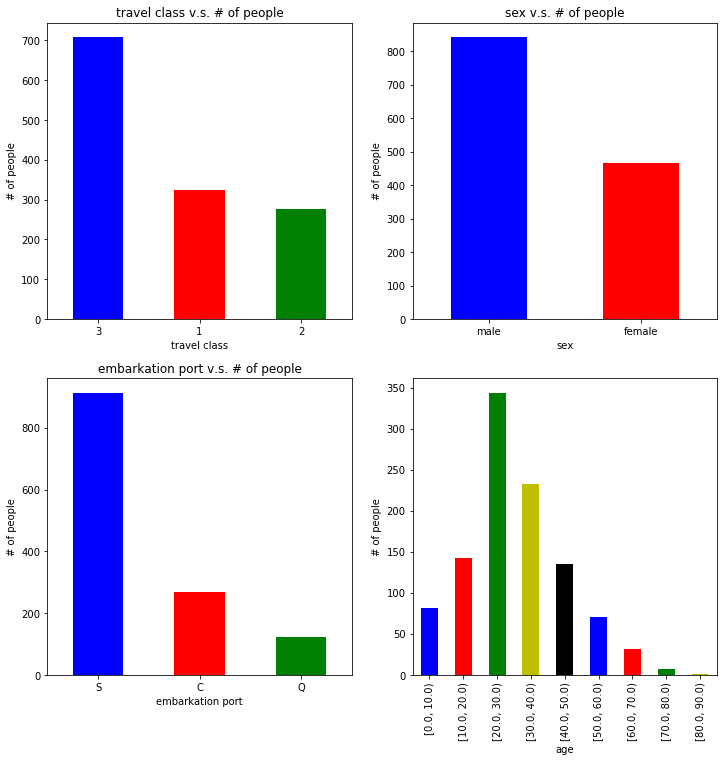

In [5]:
# function for showing the bar chart or histogram
def plot_fig(series, kind, axis, label_x = '', label_y = '', title_ = '', angle = 0):
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(series)))
    ax = series.plot(kind = kind, color = my_colors, ax = axis, figsize = (12,12), rot = angle, title = title_)
    ax.set_xlabel(label_x)
    ax.set_ylabel(label_y)

# create subplot to show the result together
fig, axes = plt.subplots(nrows=2, ncols=2)

# *****
# By definition, histogram is used when x-axis is a continuous variables
# and hence in our case, it's better using bar plot because most of the data are discrete values and strings 
# For age, I also use bar chart because the representation of intervals is string
# *****
    
# travel class v.s. # of people: travel class is discrete and hence use bar plot
plot_fig(data.pclass.value_counts(), kind = 'bar', label_x = 'travel class', label_y = '# of people', \
         axis = axes[0,0], title_ = 'travel class v.s. # of people')

# sex: string is not the case for in histogram, and hence use bar plot
plot_fig(data.sex.value_counts(), 'bar', label_x = 'sex', label_y = '# of people', axis = axes[0,1],\
        title_ = 'sex v.s. # of people')

# embarkation port: string is not used as axis in histogram, and hence use bar chart
plot_fig(data.embarked.value_counts(), 'bar', label_x = 'embarkation port', label_y = '# of people',\
         title_ = 'embarkation port v.s. # of people', axis = axes[1,0])

# age (10 years as an interval)
data_age = data.age.copy()
bin_range = np.arange(0,data_age.max() + 20,10)
out, bins  = pd.cut(data.age, bins=bin_range, include_lowest=True, right=False, retbins=True)
plot_fig(out.value_counts(sort=False), 'bar', label_x = 'age', label_y = '# of people', axis = axes[1,1], angle = 90)

## 3. Calculate the proportion of passengers by cabin floor. Present your results in a pie chart.

In [6]:
# plot function for pie charts
def plot_pie(series, label_x = '', label_y = '', title_ = ''):
    figure()
    axis('equal')
    series.plot.pie(autopct='%1.1f%%', figsize = (10,10))
    xlabel(label_x)
    ylabel(label_y)
    title(title_)

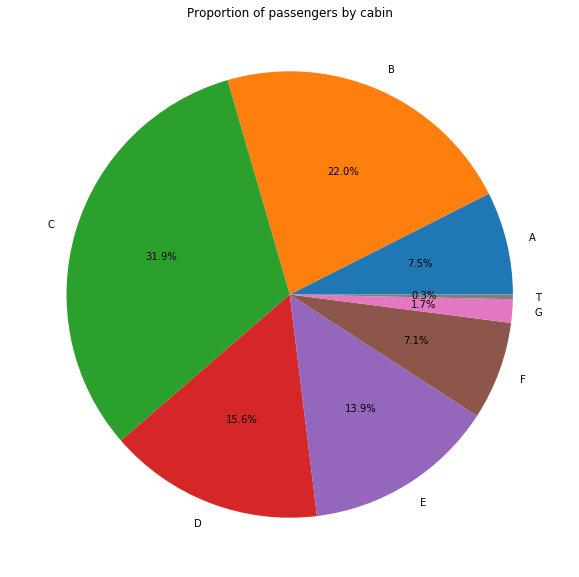

In [7]:
# Create the dataframe: cabin v.s. survive
survive_stat = pd.crosstab(data.cabin, data.survived)

# group by cabin floor
survive_stat = survive_stat.groupby(survive_stat.index).sum()

# plot the pie chart
plot_pie(survive_stat[survive_stat.columns[0]] + survive_stat[survive_stat.columns[1]], title_ = 'Proportion of passengers by cabin')


## 4. For each travel class, calculate the proportion of the passengers that survived. Present your results in pie charts.

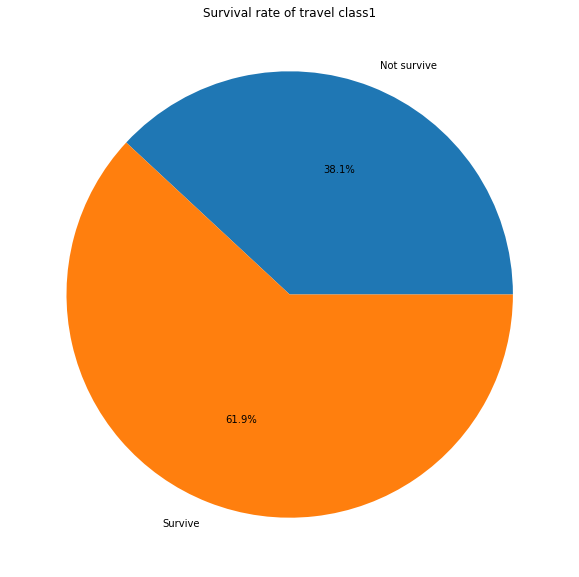

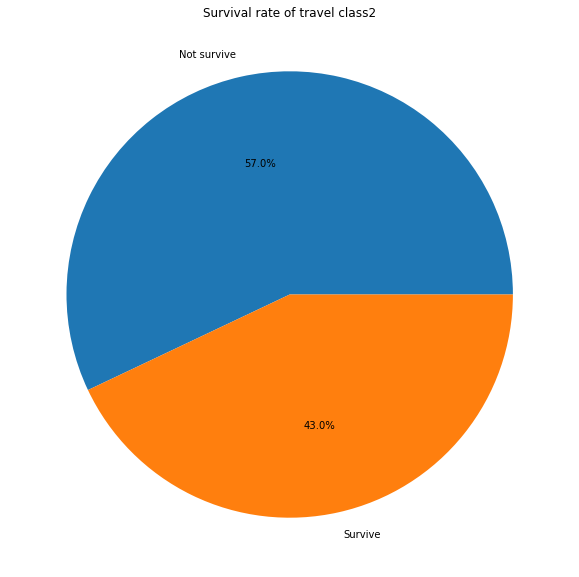

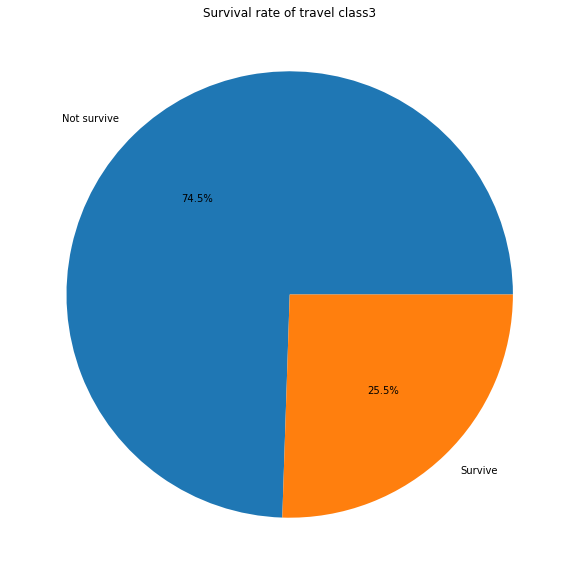

In [8]:
# generate the dataframe: survive v.s. class
survive_stat = pd.crosstab(data.survived, data.pclass)

# for each travel class, plot the pie chart
for class_no in survive_stat.columns:
    plot_pie(survive_stat[class_no], title_ = 'Survival rate of travel class' + str(class_no))


## 5. Calculate the proportion of the passengers that survived by travel class and sex. Present your results in a single histogram.

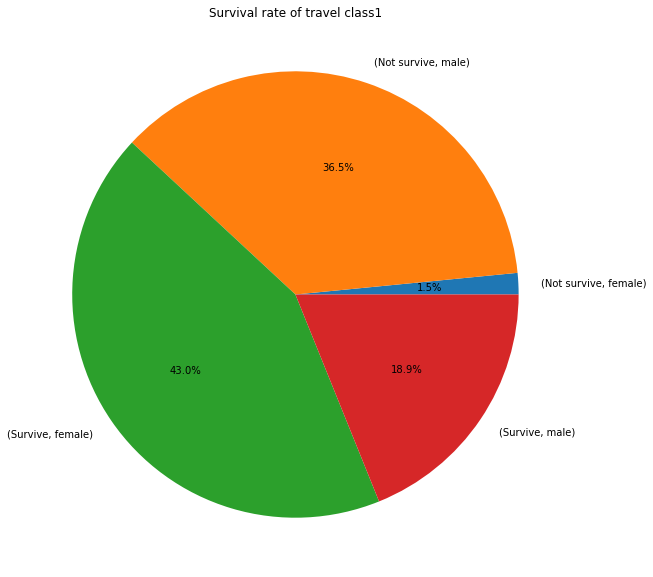

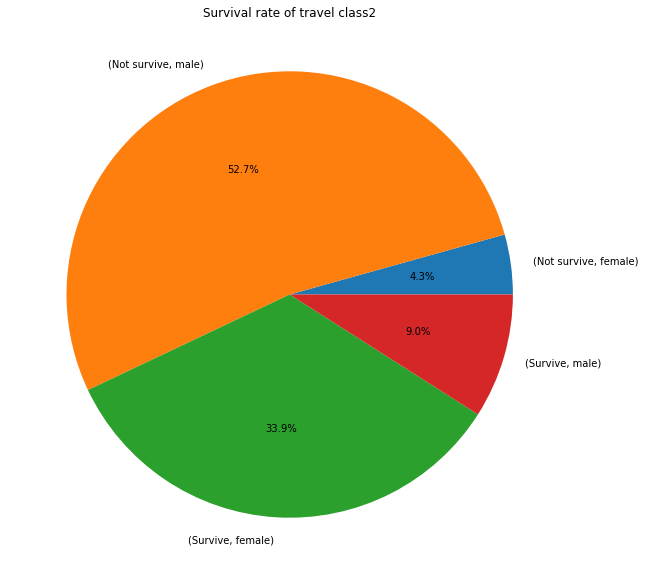

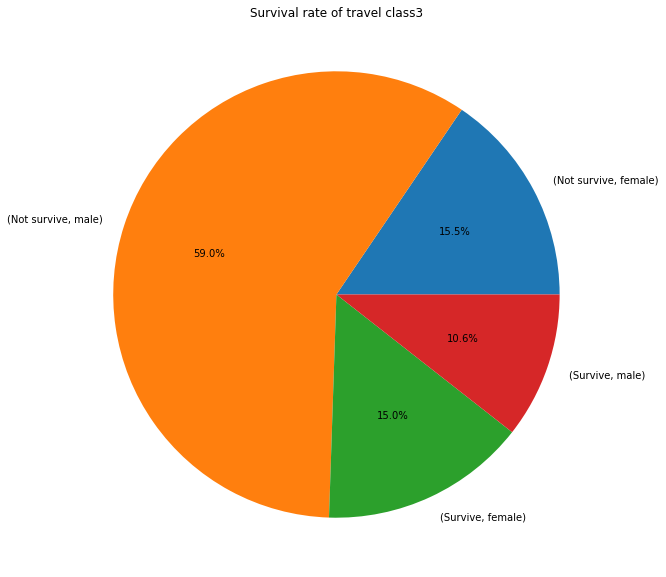

In [9]:
# generate the dataframe: (survive,sex) v.s. class
survive_stat = pd.crosstab([data.survived, data.sex], data.pclass)

# change the value of index

# for each travel class and sex, plot the pie chart
for class_no in survive_stat.columns:
    plot_pie(survive_stat[class_no], title_ = 'Survival rate of travel class' + str(class_no))

## 6. Create 2 equally populated age categories and calculate survival proportions by age category, travel class and sex. Present your results in a DataFrame with unique index.

In [10]:
# discard the rows with NaN in age attributes
data_copy = data.copy(['pclass', 'survived', 'sex', 'age'])
data_copy = data_copy[~data.age.isnull()]

# sort the age
data_copy = data_copy.sort_values('age')

# find the median of the age for the purpose of equally populated
med = np.median(data_copy.age)

# create age category: <= med and >= med
data_copy.age = ["<= " + str(med) if i < len(data_copy)/2 else ">= " + str(med) for i in range(len(data_copy))]
data_copy['age'] = data_copy.age.astype('category')

# create the dataframe with index(age, pclass, sex)
stat = pd.crosstab([data_copy.age, data_copy.pclass, data_copy.sex], data_copy.survived)

# change to int to help adding the following new column
stat.columns = stat.columns.astype('str')

# add the new column with survival rate
stat['survival rate (%)'] = [alive/(alive + dead)*100 for dead, alive in zip(stat[stat.columns[0]], stat[stat.columns[1]])]
stat

survived               Not survive  Survive  survival rate (%)
age     pclass sex                                            
<= 28.0 1      female            2       39          95.121951
               male             15       15          50.000000
        2      female            5       48          90.566038
               male             55       16          22.535211
        3      female           52       56          51.851852
               male            179       41          18.636364
>= 28.0 1      female            3       89          96.739130
               male             83       38          31.404959
        2      female            6       44          88.000000
               male             80        7           8.045977
        3      female           28       16          36.363636
               male            111       18          13.953488